In [1]:
# nltk.download('punkt') #uncomment if running on new machine

In [11]:
# Importing the libraries
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import gensim
from gensim.test.utils import datapath
from gensim.models import Word2Vec
import os
import nltk
from nltk import word_tokenize
from nltk import sent_tokenize

# Helpful variables
EXT_DATA_FOLDER = "C:\\Users\\Admin\\Projects\\thesis\\data\\"
EXT_DATA_FOLDER2 = "B:\\Datasets\\"

ANALYSIS_SAMPLES = os.path.join(EXT_DATA_FOLDER, "Credibility_Analysis_Samples\\September_25\\")
dataset_columns = ['Identifier', 'Type', 'Category', 'URL', 'Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5',
 'Cat6', 'Cat7', 'Score', 'First date_time', 'Tweets', 'Likes', 'Retweets',
 'Potential exposure', 'HTML', 'TEXT']
criterias = ["Cat1", "Cat2", "Cat3", "Cat4", "Cat5", "Cat6", "Cat7"]


### Low Credibility Score Detector

1) Create a dataset that separates he articles as having low credibility and not low credibility where low credibility is defined to be articles with a credibility score of less than 3

2.a) Apply the ensemble of models to classify an article for each category and then use the resulting score to determine whether an article's credibility is low or not

2.b) Apply a new model that has been trained to solely just determine whether an article's credibility is low or not

3) ???

4) Profit

### Retrieving the manually labelled articles from the corpus

In [6]:
from collections import defaultdict

labelled_articles = pd.read_excel("dataset5.xlsx")
labelled_articles = labelled_articles.dropna(subset=['TEXT'])
labelled_articles = labelled_articles[pd.to_numeric(labelled_articles['Cat1'], errors='coerce').notnull()]
for criteria in criterias:
    labelled_articles = labelled_articles.dropna(subset=[criteria])
print(labelled_articles.shape)

(470, 21)


### Making Training and testing sets for 2 classification tasks

1) Make a training and testing set for classfying whether an article has low credibility or not

2) Make a training and testing set for classifying whether an article satisfies each criteria and then using these outputs do determine whether the article has low crediibility

In [7]:
article_text = [article.split("TITLE: ")[1].replace("TEXT: ","").strip(" ") for article in labelled_articles["TEXT"]]
crit1_labels = labelled_articles["Cat1"]
crit2_labels = labelled_articles["Cat2"]
crit3_labels = labelled_articles["Cat3"]
crit4_labels = labelled_articles["Cat4"]
crit5_labels = labelled_articles["Cat5"]
crit6_labels = labelled_articles["Cat6"]
crit7_labels = labelled_articles["Cat7"]

In [12]:
#If score < cred_thresh than article isn't credible
cred_thresh = 3
labelled_articles['Credible'] = np.where(labelled_articles['Score'] < cred_thresh, 0, 1)
low_cred_labels = list(labelled_articles["Credible"])
seed = random.randint(1,100000)
seed

32189

In [13]:
print(len(labelled_articles[labelled_articles['Credible'] == 1]))

358


### Single Model Approach
SVM + TF-IDF with stopwords removed

In [14]:
def svm_build_train(article_text, labels, seed=42):
    X_train, X_test, y_train, y_test = train_test_split(list(article_text), [int(label) for label in labels], random_state=seed, test_size=0.10)
    svm_clf = Pipeline([('vect', CountVectorizer(stop_words='english', analyzer='word', max_features=20000)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=69,
                                               max_iter=5, tol=None)),
    ])
    svm_clf.fit(X_train, y_train)
    model = {"model": svm_clf,
             "X_train": X_train, 
             "X_test": X_test,
             "y_train": y_train,
             "y_test": y_test}

    return model

In [15]:
import random

models = defaultdict(str)
seed = random.randint(1,10000)
#Train a classifier for all 7 criteria
for criteria in criterias:
    models[criteria] = svm_build_train(article_text, labelled_articles[criteria], seed)

#Replicate the X and y test sets to get the actual credibility score
X2_train, X2_test, y2_train, credibility_scores = train_test_split(article_text, list(labelled_articles["Score"]), random_state=seed, test_size=0.10)
X2_train, X2_test, y2_train, low_credibility_labels = train_test_split(article_text, list(labelled_articles["Credible"]), random_state=seed, test_size=0.10)

#for each criteria, I get the use the model that I trained specifically for it and get it to predict on the articles stored in the X_test set
#The results are then stored in 'label_predictions' where it is a 7xN matrix where N is the number of articles in the test sets
label_predictions = []
for criteria in criterias:
    predictions = list(models[criteria]['model'].predict(models[criteria]['X_test']))
    label_predictions.append(predictions)

#The predictions are then tallied up and compared with the actual credibility score of the article
#And the score difference when it correctly and incorrectly identifies
predicted_scores = [0 for i in range(len(credibility_scores))]
for label in label_predictions:
    for article in range(len(label)):
        predicted_scores[article] = predicted_scores[article] + label[article]

print("Predicted Scores vs Actual Scores:\n{}\n{}".format(predicted_scores, credibility_scores))

identified = []
correct_diff = []
incorrect_diff = []
for i in range(len(credibility_scores)):
    if((credibility_scores[i] < cred_thresh and predicted_scores[i] < cred_thresh) or (credibility_scores[i] >= cred_thresh and predicted_scores[i] >= cred_thresh)) :
        identified.append(1)
        correct_diff.append(abs(credibility_scores[i] - predicted_scores[i]))
    else:
        incorrect_diff.append(abs(credibility_scores[i] - predicted_scores[i]))

identified_avg = len(identified)/len(credibility_scores)
print("% Correct: {}".format(identified_avg))
correct_diff_avg = np.array(correct_diff).mean()
incorrect_diff_avg = np.array(incorrect_diff).mean()
print("Average difference when correct: {}\nAverage difference when incorrect: {}".format(correct_diff_avg, incorrect_diff_avg))

#Calculating the micro averaged f1 score

#Converting the predicted scores into a credibility label
low_credibility_preds = []
for i in range(len(credibility_scores)):
        if((credibility_scores[i] < cred_thresh and predicted_scores[i] < cred_thresh)):
            low_credibility_preds.append(0)
        else:
            low_credibility_preds.append(1)
        
print("Micro averaged f1-scores: {}".format(f1_score(low_credibility_labels, low_credibility_preds, labels=[0,1], average='micro')))
print("Micro averaged precision scores: {}".format(precision_score(low_credibility_labels, low_credibility_preds, labels=[0,1], average='micro')))
print("Micro averaged recall scores: {}".format(recall_score(low_credibility_labels, low_credibility_preds, labels=[0,1], average='micro')))

Predicted Scores vs Actual Scores:
[1, 2, 4, 5, 1, 3, 3, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 0, 4, 4, 3, 4, 3, 3, 5, 4, 4, 3, 2, 3, 4, 2, 4, 4, 2, 4, 4, 4, 0, 4, 3, 3, 5]
[0, 2, 4, 4, 3, 5, 5, 5, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 3, 4, 4, 1, 4, 4, 4, 4, 1, 3, 6, 4, 6, 2, 2, 1, 4, 2, 4, 3, 5, 5, 5, 1, 1, 3, 1, 4, 6]
% Correct: 0.851063829787234
Average difference when correct: 0.525
Average difference when incorrect: 2.142857142857143
Micro averaged f1-scores: 0.8936170212765957
Micro averaged precision scores: 0.8936170212765957
Micro averaged recall scores: 0.8936170212765957


In [16]:
"""
svm_predicted = list(svm_clf.predict(X_test))
svm_cv_scores = cross_val_score(svm_clf, X_train, y_train, cv=10, scoring='f1_micro')

print("SVM Average micro f1-score: %0.2f (+/- %0.2f)" % (svm_cv_scores.mean(), svm_cv_scores.std()))
joblib.dump(svm_clf, 'models/svm_clf_tfidf_stop_' + criteria + '.joblib')
"""

'\nsvm_predicted = list(svm_clf.predict(X_test))\nsvm_cv_scores = cross_val_score(svm_clf, X_train, y_train, cv=10, scoring=\'f1_micro\')\n\nprint("SVM Average micro f1-score: %0.2f (+/- %0.2f)" % (svm_cv_scores.mean(), svm_cv_scores.std()))\njoblib.dump(svm_clf, \'models/svm_clf_tfidf_stop_\' + criteria + \'.joblib\')\n'

### Multiple runs of test to get idea of average accuracy and average difference between scores

In [17]:

total_identified = []
total_correct_diff = []
total_incorrect_diff = []
total_single_low_cred_preds = []
total_low_cred_labels = []

num_runs = 10
for i in range(num_runs):
    models = defaultdict(str)
    #Train a classifier for all 7 criteria
    for criteria in criterias:
        models[criteria] = svm_build_train(article_text, labelled_articles[criteria], seed)

    #Replicate the X and y test sets to get the actual credibility score
    X2_train, X2_test, y2_train, credibility_scores = train_test_split(article_text, list(labelled_articles["Score"]), random_state=seed, test_size=0.10)

    #for each criteria, I get the use the model that I trained specifically for it and get it to predict on the articles stored in the X_test set
    #The results are then stored in 'label_predictions' where it is a 7xN matrix where N is the number of articles in the test sets
    label_predictions = []
    for criteria in criterias:
        predictions = list(models[criteria]['model'].predict(models[criteria]['X_test']))
        label_predictions.append(predictions)

    #The predictions are then tallied up and compared with the actual credibility score of the article
    #And the score difference when it correctly and incorrectly identifies
    predicted_scores = [0 for i in range(len(credibility_scores))]
    for label in label_predictions:
        for article in range(len(label)):
            predicted_scores[article] = predicted_scores[article] + label[article]
    identified = []
    correct_diff = []
    incorrect_diff = []
    for i in range(len(credibility_scores)):
        if((credibility_scores[i] < cred_thresh and predicted_scores[i] < cred_thresh) or (credibility_scores[i] >= cred_thresh and predicted_scores[i] >= cred_thresh)) :
            identified.append(1)
            correct_diff.append(abs(credibility_scores[i] - predicted_scores[i]))
        else:
            incorrect_diff.append(abs(credibility_scores[i] - predicted_scores[i]))
            
    if(np.array(correct_diff).size == 0):
        correct_diff = [0]
    
    if(np.array(incorrect_diff).size == 0):
        incorrect_diff = [0]

    identified_avg = len(identified)/len(credibility_scores)
    correct_diff_avg = np.array(correct_diff).mean()
    incorrect_diff_avg = np.array(incorrect_diff).mean()
    
    total_identified.append(identified_avg)
    total_correct_diff.append(correct_diff_avg)
    total_incorrect_diff.append(incorrect_diff_avg)
    
    #Calculating the micro averaged f1 score

    #Converting the predicted scores into a credibility label
    low_credibility_preds = []
    for i in range(len(credibility_scores)):
            if((credibility_scores[i] < cred_thresh and predicted_scores[i] < cred_thresh)):
                low_credibility_preds.append(0)
            else:
                low_credibility_preds.append(1)
    total_single_low_cred_preds.extend(low_credibility_preds)
    total_low_cred_labels.extend(low_credibility_labels)
    
    
if(np.array(total_incorrect_diff).size == 0):
    total_incorrect_diff = [0]
    
    
print("""
For {} runs:\n
Average correctly identified %: {}\n
Average score difference when correctly classified: {}\n
Average score difference when incorrectly classified: {}
""".format(num_runs, np.array(total_identified).mean(), np.array(total_correct_diff).mean(), np.array(total_incorrect_diff).mean()))



print("Micro averaged f1-scores: {}".format(f1_score(total_low_cred_labels, total_single_low_cred_preds, labels=[0,1], average='micro')))
print("Micro averaged precision scores: {}".format(precision_score(total_low_cred_labels, total_single_low_cred_preds, labels=[0,1], average='micro')))
print("Micro averaged recall scores: {}".format(recall_score(total_low_cred_labels, total_single_low_cred_preds, labels=[0,1], average='micro')))


For 10 runs:

Average correctly identified %: 0.851063829787234

Average score difference when correctly classified: 0.5250000000000001

Average score difference when incorrectly classified: 2.142857142857143

Micro averaged f1-scores: 0.8936170212765957
Micro averaged precision scores: 0.8936170212765957
Micro averaged recall scores: 0.8936170212765957


In [18]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 80  50]
 [  0 340]]


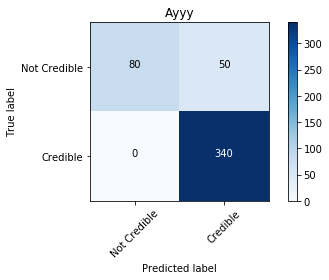

In [19]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(total_low_cred_labels, total_single_low_cred_preds)
tn, fp, fn, tp = confusion_matrix(total_low_cred_labels, total_single_low_cred_preds).ravel()
plot_confusion_matrix(confusion, classes=["Not Credible", "Credible"], title="Ayyy")

### Ensemble Approach
Criteria 1: SVM + TF-IDF (stopwords removed)

Criteria 2: SVM + TF-IDF (stopwords removed)

Criteria 3: SVM + BoW (stopwords removed)

Criteria 4: SVM + BoW (stopwords removed)

Criteria 5: SVM + TF-IDF (stopwords removed)

Criteria 6: SVM + TF-IDF (stopwords removed)

Criteria 7: SVM + BoW (all words)

In [20]:
def ensemble_build_train(labelled_articles, seed=42):
    
    c1_clf = Pipeline([('vect', CountVectorizer(stop_words='english', analyzer='word', max_features=20000)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=69,
                                               max_iter=5, tol=None)),])
    c2_clf = Pipeline([('vect', CountVectorizer(stop_words='english', analyzer='word', max_features=20000)),
                        ('tfidf', TfidfTransformer()),
                         ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=69,
                                               max_iter=5, tol=None)),])
    c3_clf = Pipeline([('vect', CountVectorizer(stop_words='english', analyzer='word', max_features=20000)),
                         ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=69,
                                               max_iter=5, tol=None)),])
    c4_clf = Pipeline([('vect', CountVectorizer(stop_words='english', analyzer='word', max_features=20000)),
                         ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=69,
                                               max_iter=5, tol=None)),])
    c5_clf = Pipeline([('vect', CountVectorizer(stop_words='english', analyzer='word', max_features=20000)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=69,
                                               max_iter=5, tol=None)),])
    c6_clf = Pipeline([('vect', CountVectorizer(stop_words='english', analyzer='word', max_features=20000)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=69,
                                               max_iter=5, tol=None)),])
    c7_clf = Pipeline([('vect', CountVectorizer(max_features=20000)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                               alpha=1e-3, random_state=69,
                                               max_iter=5, tol=None)),])
    
    article_text = list(labelled_articles["TEXT"])
    crit1_labels = [int(label) for label in list(labelled_articles["Cat1"])]
    crit2_labels = [int(label) for label in list(labelled_articles["Cat2"])]
    crit3_labels = [int(label) for label in list(labelled_articles["Cat3"])]
    crit4_labels = [int(label) for label in list(labelled_articles["Cat4"])]
    crit5_labels = [int(label) for label in list(labelled_articles["Cat5"])]
    crit6_labels = [int(label) for label in list(labelled_articles["Cat6"])]
    crit7_labels = [int(label) for label in list(labelled_articles["Cat7"])]
    
    X1_train, X1_test, y1_train, y1_test = train_test_split(article_text, crit1_labels, random_state=seed, test_size=0.10)
    X2_train, X2_test, y2_train, y2_test = train_test_split(article_text, crit2_labels, random_state=seed, test_size=0.10)
    X3_train, X3_test, y3_train, y3_test = train_test_split(article_text, crit3_labels, random_state=seed, test_size=0.10)
    X4_train, X4_test, y4_train, y4_test = train_test_split(article_text, crit4_labels, random_state=seed, test_size=0.10)
    X5_train, X5_test, y5_train, y5_test = train_test_split(article_text, crit5_labels, random_state=seed, test_size=0.10)
    X6_train, X6_test, y6_train, y6_test = train_test_split(article_text, crit6_labels, random_state=seed, test_size=0.10)
    X7_train, X7_test, y7_train, y7_test = train_test_split(article_text, crit7_labels, random_state=seed, test_size=0.10)
    
    c1_clf.fit(X1_train,y1_train)
    c2_clf.fit(X2_train,y2_train)
    c3_clf.fit(X3_train,y3_train)
    c4_clf.fit(X4_train,y4_train)
    c5_clf.fit(X5_train,y5_train)
    c6_clf.fit(X6_train,y6_train)
    c7_clf.fit(X7_train,y7_train)
    
    ensemble = {"Cat1": {"model": c1_clf, "X_train": X1_train, "X_test": X1_test, "y_train": y1_train, "y_test": y1_test},
                "Cat2": {"model": c2_clf, "X_train": X2_train, "X_test": X2_test, "y_train": y2_train, "y_test": y2_test},
                "Cat3": {"model": c3_clf, "X_train": X3_train, "X_test": X3_test, "y_train": y3_train, "y_test": y3_test},
                "Cat4": {"model": c4_clf, "X_train": X4_train, "X_test": X4_test, "y_train": y4_train, "y_test": y4_test},
                "Cat5": {"model": c5_clf, "X_train": X5_train, "X_test": X5_test, "y_train": y5_train, "y_test": y5_test},
                "Cat6": {"model": c6_clf, "X_train": X6_train, "X_test": X6_test, "y_train": y6_train, "y_test": y6_test},
                "Cat7": {"model": c7_clf, "X_train": X7_train, "X_test": X7_test, "y_train": y7_train, "y_test": y7_test}
               }

    return ensemble

In [21]:

total_identified = []
total_correct_diff = []
total_incorrect_diff = []
total_ensemble_low_cred_preds = []
total_low_cred_labels = []

num_runs = 10
for i in range(num_runs):
    #Train a ensemble classifier for all 7 criteria
    ensemble = ensemble_build_train(labelled_articles, seed)

    #Replicate the X and y test sets to get the actual credibility score
    __train, __test, __train, credibility_scores = train_test_split(article_text, list(labelled_articles["Score"]), random_state=seed, test_size=0.10)

    #for each criteria, I get the use the model that I trained specifically for it and get it to predict on the articles stored in the X_test set
    #The results are then stored in 'label_predictions' where it is a 7xN matrix where N is the number of articles in the test sets
    label_predictions = []
    for criteria in criterias:
        predictions = list(ensemble[criteria]['model'].predict(ensemble[criteria]['X_test']))
        label_predictions.append(predictions)

    #The predictions are then tallied up and compared with the actual credibility score of the article
    #And the score difference when it correctly and incorrectly identifies
    predicted_scores = [0 for i in range(len(credibility_scores))]
    for label in label_predictions:
        for article in range(len(label)):
            predicted_scores[article] = predicted_scores[article] + label[article]
    identified = []
    correct_diff = []
    incorrect_diff = []
    for i in range(len(credibility_scores)):
        if((credibility_scores[i] < cred_thresh and predicted_scores[i] < cred_thresh) or (credibility_scores[i] >= cred_thresh and predicted_scores[i] >= cred_thresh)) :
            identified.append(1)
            correct_diff.append(abs(credibility_scores[i] - predicted_scores[i]))
        else:
            incorrect_diff.append(abs(credibility_scores[i] - predicted_scores[i]))

    identified_avg = len(identified)/len(credibility_scores)
    correct_diff_avg = np.array(correct_diff).mean()
    incorrect_diff_avg = np.array(incorrect_diff).mean()
    
    total_identified.append(identified_avg)
    total_correct_diff.append(correct_diff_avg)
    total_incorrect_diff.append(incorrect_diff_avg)
    
    #Calculating the micro averaged f1 score

    #Converting the predicted scores into a credibility label
    low_credibility_preds = []
    for i in range(len(credibility_scores)):
            if((credibility_scores[i] < cred_thresh and predicted_scores[i] < cred_thresh)):
                low_credibility_preds.append(0)
            else:
                low_credibility_preds.append(1)
    total_ensemble_low_cred_preds.extend(low_credibility_preds)
    total_low_cred_labels.extend(low_credibility_labels)
    
    
if(np.isnan(np.array(total_incorrect_diff).mean())):
    total_incorrect_df = [0]
    
    
print("""
For {} runs:\n
Average correctly identified %: {}\n
Average score difference when correctly classified: {}\n
Average score difference when incorrectly classified: {}
""".format(num_runs, np.array(total_identified).mean(), np.array(total_correct_diff).mean(), np.array(total_incorrect_diff).mean()))



print("Micro averaged f1-scores: {}".format(f1_score(total_low_cred_labels, total_ensemble_low_cred_preds, labels=[0,1], average='micro')))
print("Micro averaged precision scores: {}".format(precision_score(total_low_cred_labels, total_ensemble_low_cred_preds, labels=[0,1], average='micro')))
print("Micro averaged recall scores: {}".format(recall_score(total_low_cred_labels, total_ensemble_low_cred_preds, labels=[0,1], average='micro')))


For 10 runs:

Average correctly identified %: 0.8936170212765957

Average score difference when correctly classified: 0.5476190476190477

Average score difference when incorrectly classified: 2.0

Micro averaged f1-scores: 0.9148936170212766
Micro averaged precision scores: 0.9148936170212766
Micro averaged recall scores: 0.9148936170212766


Confusion matrix, without normalization
[[ 90  40]
 [  0 340]]


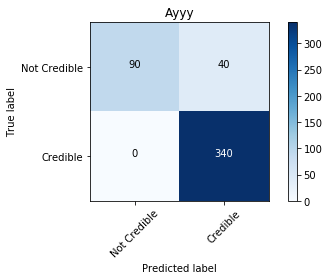

In [22]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(total_low_cred_labels, total_ensemble_low_cred_preds)
tn, fp, fn, tp = confusion_matrix(total_low_cred_labels, total_ensemble_low_cred_preds).ravel()
plot_confusion_matrix(confusion, classes=["Not Credible", "Credible"], title="Ayyy")